This notebook messes around with the output of the genome query neighborhoods and orpheum, which give the reads translated into protein sequences.
The original goal was to be able to do metapangenome comparisons on the query neighborhoods, but it was hard to link up the dominating set differential abundance analysis back to the reads (because they were diginorm'd and hardtrimmed), so I ended up abandoning this approach.

+ X GCF_002234575.2--s__Enterocloster_bolteae.sig 605 605
+ X GCF_900113155.1--s__Enterocloster_clostridioformis 604 604
+ X GCF_000424325.1--s__Enterocloster_clostridioformis_A 605 604
+ X GCF_005845215.1--s__Enterocloster_sp005845215.sig 605 605
+ X GCF_008121495.1--s__Ruminococcus_B_gnavus.sig   605 604

In [8]:
setwd("..")

In [5]:
library(pagoo)
library(readr)
library(ggplot2)
library(aplot)
library(dplyr)
library(pheatmap)
library(RColorBrewer)

### sourmash compare 

In [15]:
metadata <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(library_name, study_accession, diagnosis) %>%
  distinct() %>%
  mutate(diagnosis = factor(diagnosis, levels = c("nonIBD", "CD", "UC")))

In [16]:
comp <- read_csv("sandbox/sgc_genome_queries_orpheum_species_comp/s__Ruminococcus_B_gnavus.csv", show_col_types = F)
rownames(comp) <- colnames(comp)
comp <- as.matrix(comp)

Warning message:
“Setting row names on a tibble is deprecated.”


In [17]:
hclust_comp <- hclust(dist(comp))
hclust_comp_df <- data.frame(library_name = hclust_comp$labels,
                             order = hclust_comp$order) %>%
  arrange(order)

In [18]:
head(hclust_comp_df)

library_name order
1 PSM6XBRK     1    
2 G83885       2    
3 G36350       3    
4 G36379       4    
5 Pond-249902  5    
6 bgi-MH0011   6

In [19]:
annot_col_df <- metadata %>%
  tibble::column_to_rownames("library_name") %>%
  select(-study_accession)

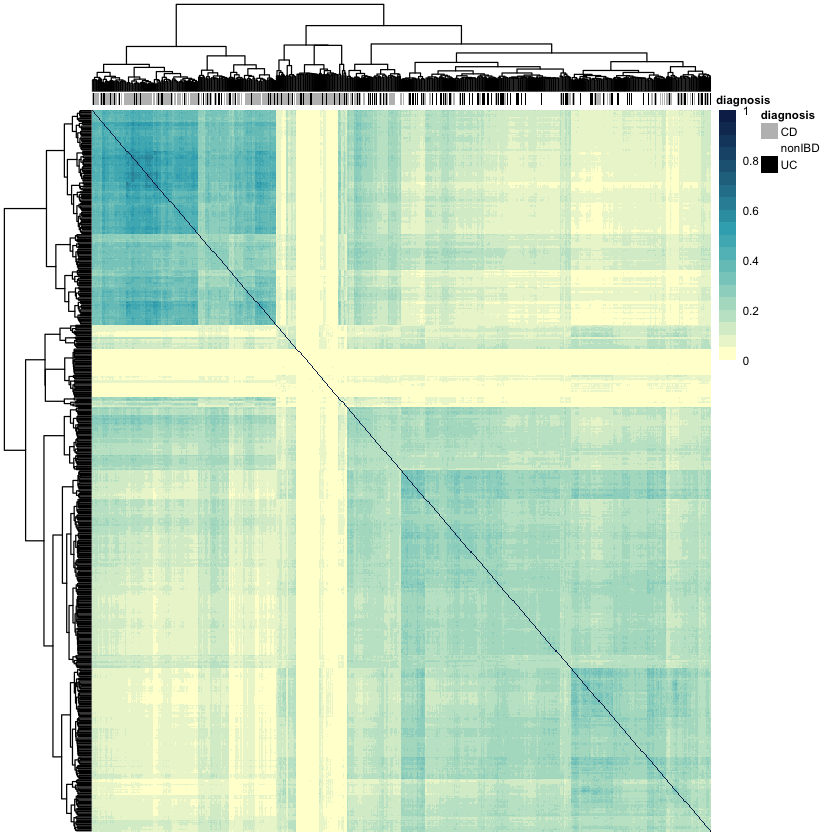

In [21]:
breaklist <- seq(0, 1, by = .05)
pheatmap::pheatmap(comp, fontsize = 7, 
                   border_color = NA, 
                   breaks = breaklist,
                   color = colorRampPalette(c("#fffed4", "#3aadbd", "#0a1a4b"))(length(breaklist)),
                   annotation_col = annot_col_df,
                   annotation_colors = list(diagnosis = c(CD="grey", nonIBD="white", UC="black")),
                   show_rownames = F, 
                   show_colnames = F) #filename = "tmp2.png")

### pagoo

In [31]:
read_long_sketch_table_as_pagoo <- function(path, sample_threshold = 2000, kmer_threshold=10){
  # path: path to sketch table
  # sample_threshold: number of k-mers a sample must have to be included
  # kmer_threshold: number of samples a k-mer must occr in to be included
  
  #path <- paste0("outputs/sgc_genome_queries_orpheum_species_sketch_table/", species_string1, "_long.csv")
  sketch_table <- read_csv(path, show_col_types = F)
  
  # filter samples that don't have enough k-mers for the species
  sketch_table_sample_grp <- sketch_table %>%
    group_by(acc) %>%
    tally()
  
  print(sketch_table_sample_grp)
  
  sample_keep <- sketch_table_sample_grp %>%
    filter(n > sample_threshold)
  
  sketch_table_kmer_grp <- sketch_table %>%
    group_by(minhash) %>%
    tally()
  
  kmer_keep <- sketch_table_kmer_grp %>%
    filter(n > kmer_threshold)
  
  sketch_table <- sketch_table %>%
    filter(acc %in% sample_keep$acc) %>%
    filter(minhash %in% kmer_keep$minhash) %>%
    select(gene    = minhash, 
           org     = acc,
           cluster = minhash) 
  p <- pagoo(data = as.data.frame(sketch_table))
  return(p)
}

In [32]:
metadata <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(library_name, study_accession, diagnosis) %>%
  distinct()

In [33]:
species_string <- "GCF_000424325.1--s__Enterocloster_clostridioformis_A"
species_string1 <- species_string
species_string2 <- gsub("-", ".", species_string1)
species_string3 <- gsub(".*s__", "", species_string2)
species_string3 <- gsub("_", " ", species_string3)
species_string4 <- gsub(".*\\.", "", species_string2)
species_string4 <- gsub("(.*__.*?)_(.*?)", "\\1 \\2 ", species_string4)
species_string4 <- gsub("  ", " ", species_string4)

In [34]:
pg <- read_long_sketch_table_as_pagoo(paste0("outputs/sgc_genome_queries_orpheum_species_sketch_table/", 
                                             species_string1, "_long.csv"), 
                                      sample_threshold = 2000, 
                                      kmer_threshold = 3)

# A tibble: 604 × 2
   acc                                                           n
   <chr>                                                     <int>
 1 4000.GCF_000424325.1..s__Enterocloster_clostridioformis_A   648
 2 4001.GCF_000424325.1..s__Enterocloster_clostridioformis_A   845
 3 4002.GCF_000424325.1..s__Enterocloster_clostridioformis_A  1202
 4 4004.GCF_000424325.1..s__Enterocloster_clostridioformis_A  1831
 5 4005.GCF_000424325.1..s__Enterocloster_clostridioformis_A   685
 6 4006.GCF_000424325.1..s__Enterocloster_clostridioformis_A  1131
 7 4007.GCF_000424325.1..s__Enterocloster_clostridioformis_A   528
 8 4009.GCF_000424325.1..s__Enterocloster_clostridioformis_A  1053
 9 4010.GCF_000424325.1..s__Enterocloster_clostridioformis_A  1817
10 4011.GCF_000424325.1..s__Enterocloster_clostridioformis_A  2087
# … with 594 more rows


Checking class.

Checking dimnames.

Creating gid (gene ids).

Creating panmatrix.

Populating class.



In [35]:
# edit pg organism names to match metadata; use this vector to filter metadata
pg_organisms <- gsub(paste0(".", species_string2), "", as.character(pg$organisms$org))
pg_organisms <- gsub("\\.01", "-01", pg_organisms)
pg_organisms <- gsub("\\.02", "-02", pg_organisms)
pg_organisms <- gsub("bgi\\.", "bgi-", pg_organisms)
pg_organisms <- gsub("UC\\.", "UC-", pg_organisms)
pg_organisms <- gsub("CD\\.", "CD-", pg_organisms)
pg_organisms <- gsub("Pond\\.", "Pond-", pg_organisms)

In [41]:
metadata2 <- metadata %>%
  filter(library_name %in% pg_organisms) %>%
  mutate(org = paste0(library_name, ".", species_string2),
         org = gsub("-01", "\\.01", org),
         org = gsub("-02", "\\.02", org),
         org = gsub("bgi-", "big\\.", org),
         org = gsub("UC-", "UC\\.", org),
         org = gsub("CD-", "CD\\.", org),
         org = gsub("Pond-", "Pond\\.", org),
         org = as.factor(org))

In [42]:
head(metadata2)

library_name study_accession diagnosis
1 Pond-249851  PRJNA237362     CD       
2 Pond-249873  PRJNA237362     CD       
3 Pond-249843  PRJNA237362     CD       
4 Pond-249882  PRJNA237362     CD       
5 Pond-249912  PRJNA237362     CD       
6 Pond-249855  PRJNA237362     CD       
  org                                                             
1 Pond.249851.GCF_000424325.1..s__Enterocloster_clostridioformis_A
2 Pond.249873.GCF_000424325.1..s__Enterocloster_clostridioformis_A
3 Pond.249843.GCF_000424325.1..s__Enterocloster_clostridioformis_A
4 Pond.249882.GCF_000424325.1..s__Enterocloster_clostridioformis_A
5 Pond.249912.GCF_000424325.1..s__Enterocloster_clostridioformis_A
6 Pond.249855.GCF_000424325.1..s__Enterocloster_clostridioformis_A

In [45]:
table(pg$organisms %in% metadata2$org)

    FALSE TRUE
org    16  202

In [44]:
pg$add_metadata(map = "org", as.data.frame(metadata2))

ERROR: Error in pg$add_metadata(map = "org", as.data.frame(metadata2)): data$org do not match with object organisms.


In [46]:
pg_sample_clust <- hclust(dist(pg$pan_matrix, method = "binary"))
pg_kmer_clust <- hclust(dist(t(pg$pan_matrix), method = "binary"))

In [47]:
row_annot <- metadata2 %>%
  tibble::column_to_rownames("org") %>%
  select(diagnosis)
breaklist <- seq(0, 1, by = 1)

In [48]:
# use matrix and order by sourmash compare similarity instead of hclust on presence absence
mat <- pg$pan_matrix
rownames(mat) <- gsub(paste0(".", species_string2), "", rownames(mat))
rownames(mat) <- gsub("\\.01", "-01", rownames(mat))
rownames(mat) <- gsub("\\.02", "-02", rownames(mat))
rownames(mat) <- gsub("bgi\\.", "bgi-", rownames(mat))
rownames(mat) <- gsub("UC\\.", "UC-", rownames(mat))
rownames(mat) <- gsub("CD\\.", "CD-", rownames(mat))
rownames(mat) <- gsub("Pond\\.", "Pond-", rownames(mat))
hclust_comp_df_filtered <- hclust_comp_df %>%
  filter(library_name %in% rownames(mat))
mat <- mat[order(match(rownames(mat), hclust_comp_df_filtered$library_name)), ]

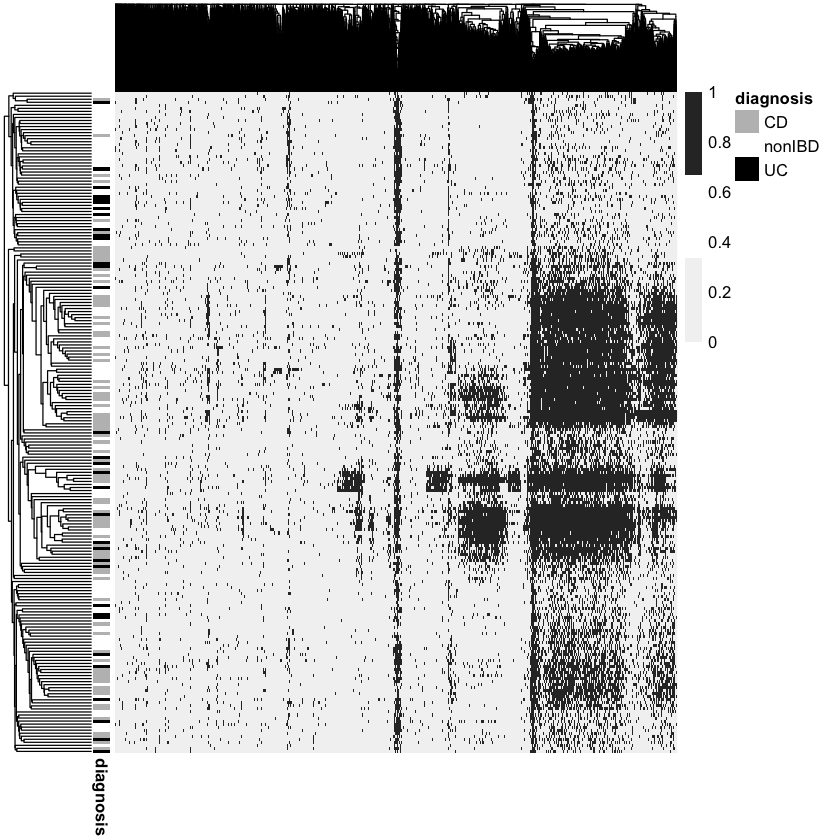

In [50]:
pheatmap(mat,
         color = colorRampPalette(c("grey95", "white", "grey19"))(3),
         clustering_distance_rows = "binary",
         show_rownames = F, 
         show_colnames = F, 
         cluster_cols = pg_kmer_clust,
         cluster_rows = T,
         annotation_row = row_annot,
         annotation_colors = list(diagnosis = c(CD="grey", nonIBD="white", UC="black")))
         #filename = "tmp_clos_A.png")

In [51]:
tpm <- t(pg$pan_matrix)
tpm[which(tpm > 0, arr.ind = TRUE)] <- 1L
bm <- as.data.frame(tpm)
or <- order(rowSums(bm), decreasing = TRUE)
lvls <- rownames(bm)[or]
bm$Cluster <- factor(rownames(bm), levels = lvls)
bm <- reshape2::melt(bm, 'Cluster')
bm$value <- factor(bm$value, levels = c(1, 0))
bm <- left_join(bm, metadata2, by = c("variable" = "org"))
bm$value_diagnosis <- paste0(bm$value, "_", bm$diagnosis)
bm$value_diagnosis <- factor(bm$value_diagnosis, 
                             levels = c("0_nonIBD", "1_nonIBD", 
                                        "0_CD", "1_CD", "0_UC", "1_UC", "0_NA", "1_NA"))
colnames(bm)[which(colnames(bm) == 'variable')] <- "Organism"

In [52]:
bm <- left_join(bm, hclust_comp_df_filtered)
bm <- bm %>%
  arrange(order)

Joining, by = "library_name"


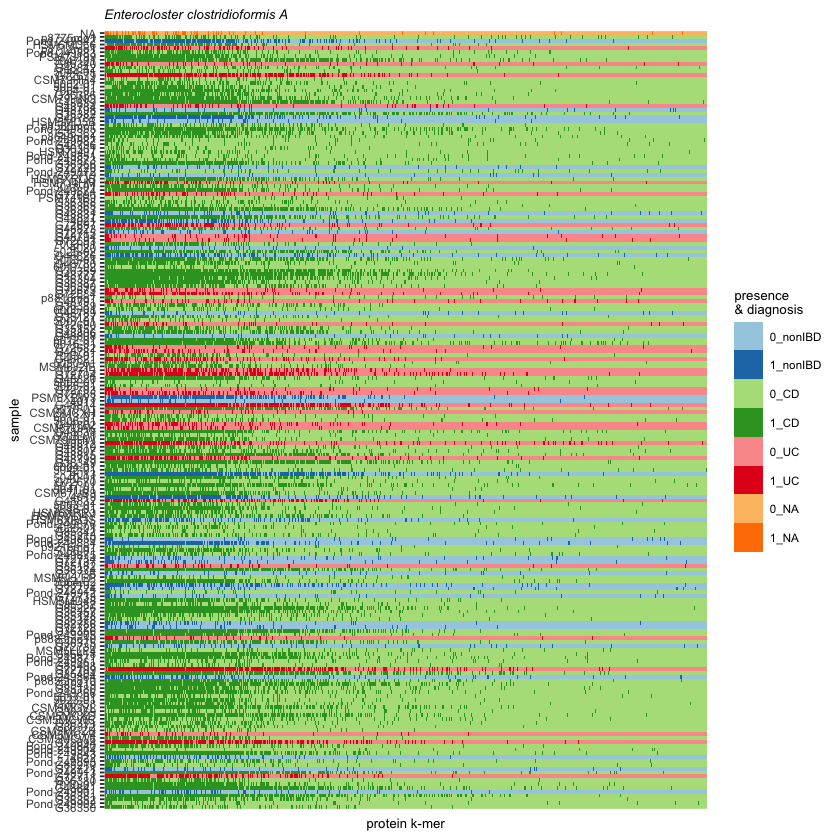

In [53]:
binmap <- ggplot(bm, aes(Cluster, y = reorder(library_name, order), fill=value_diagnosis)) +
  geom_raster() +
  theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        plot.title = element_text(face = "italic", size = 8),
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 8),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 7)) +
  scale_fill_brewer(palette = "Paired") +
  labs(x = "protein k-mer", y = "sample", fill = "presence\n& diagnosis",
       title = species_string3)
binmap

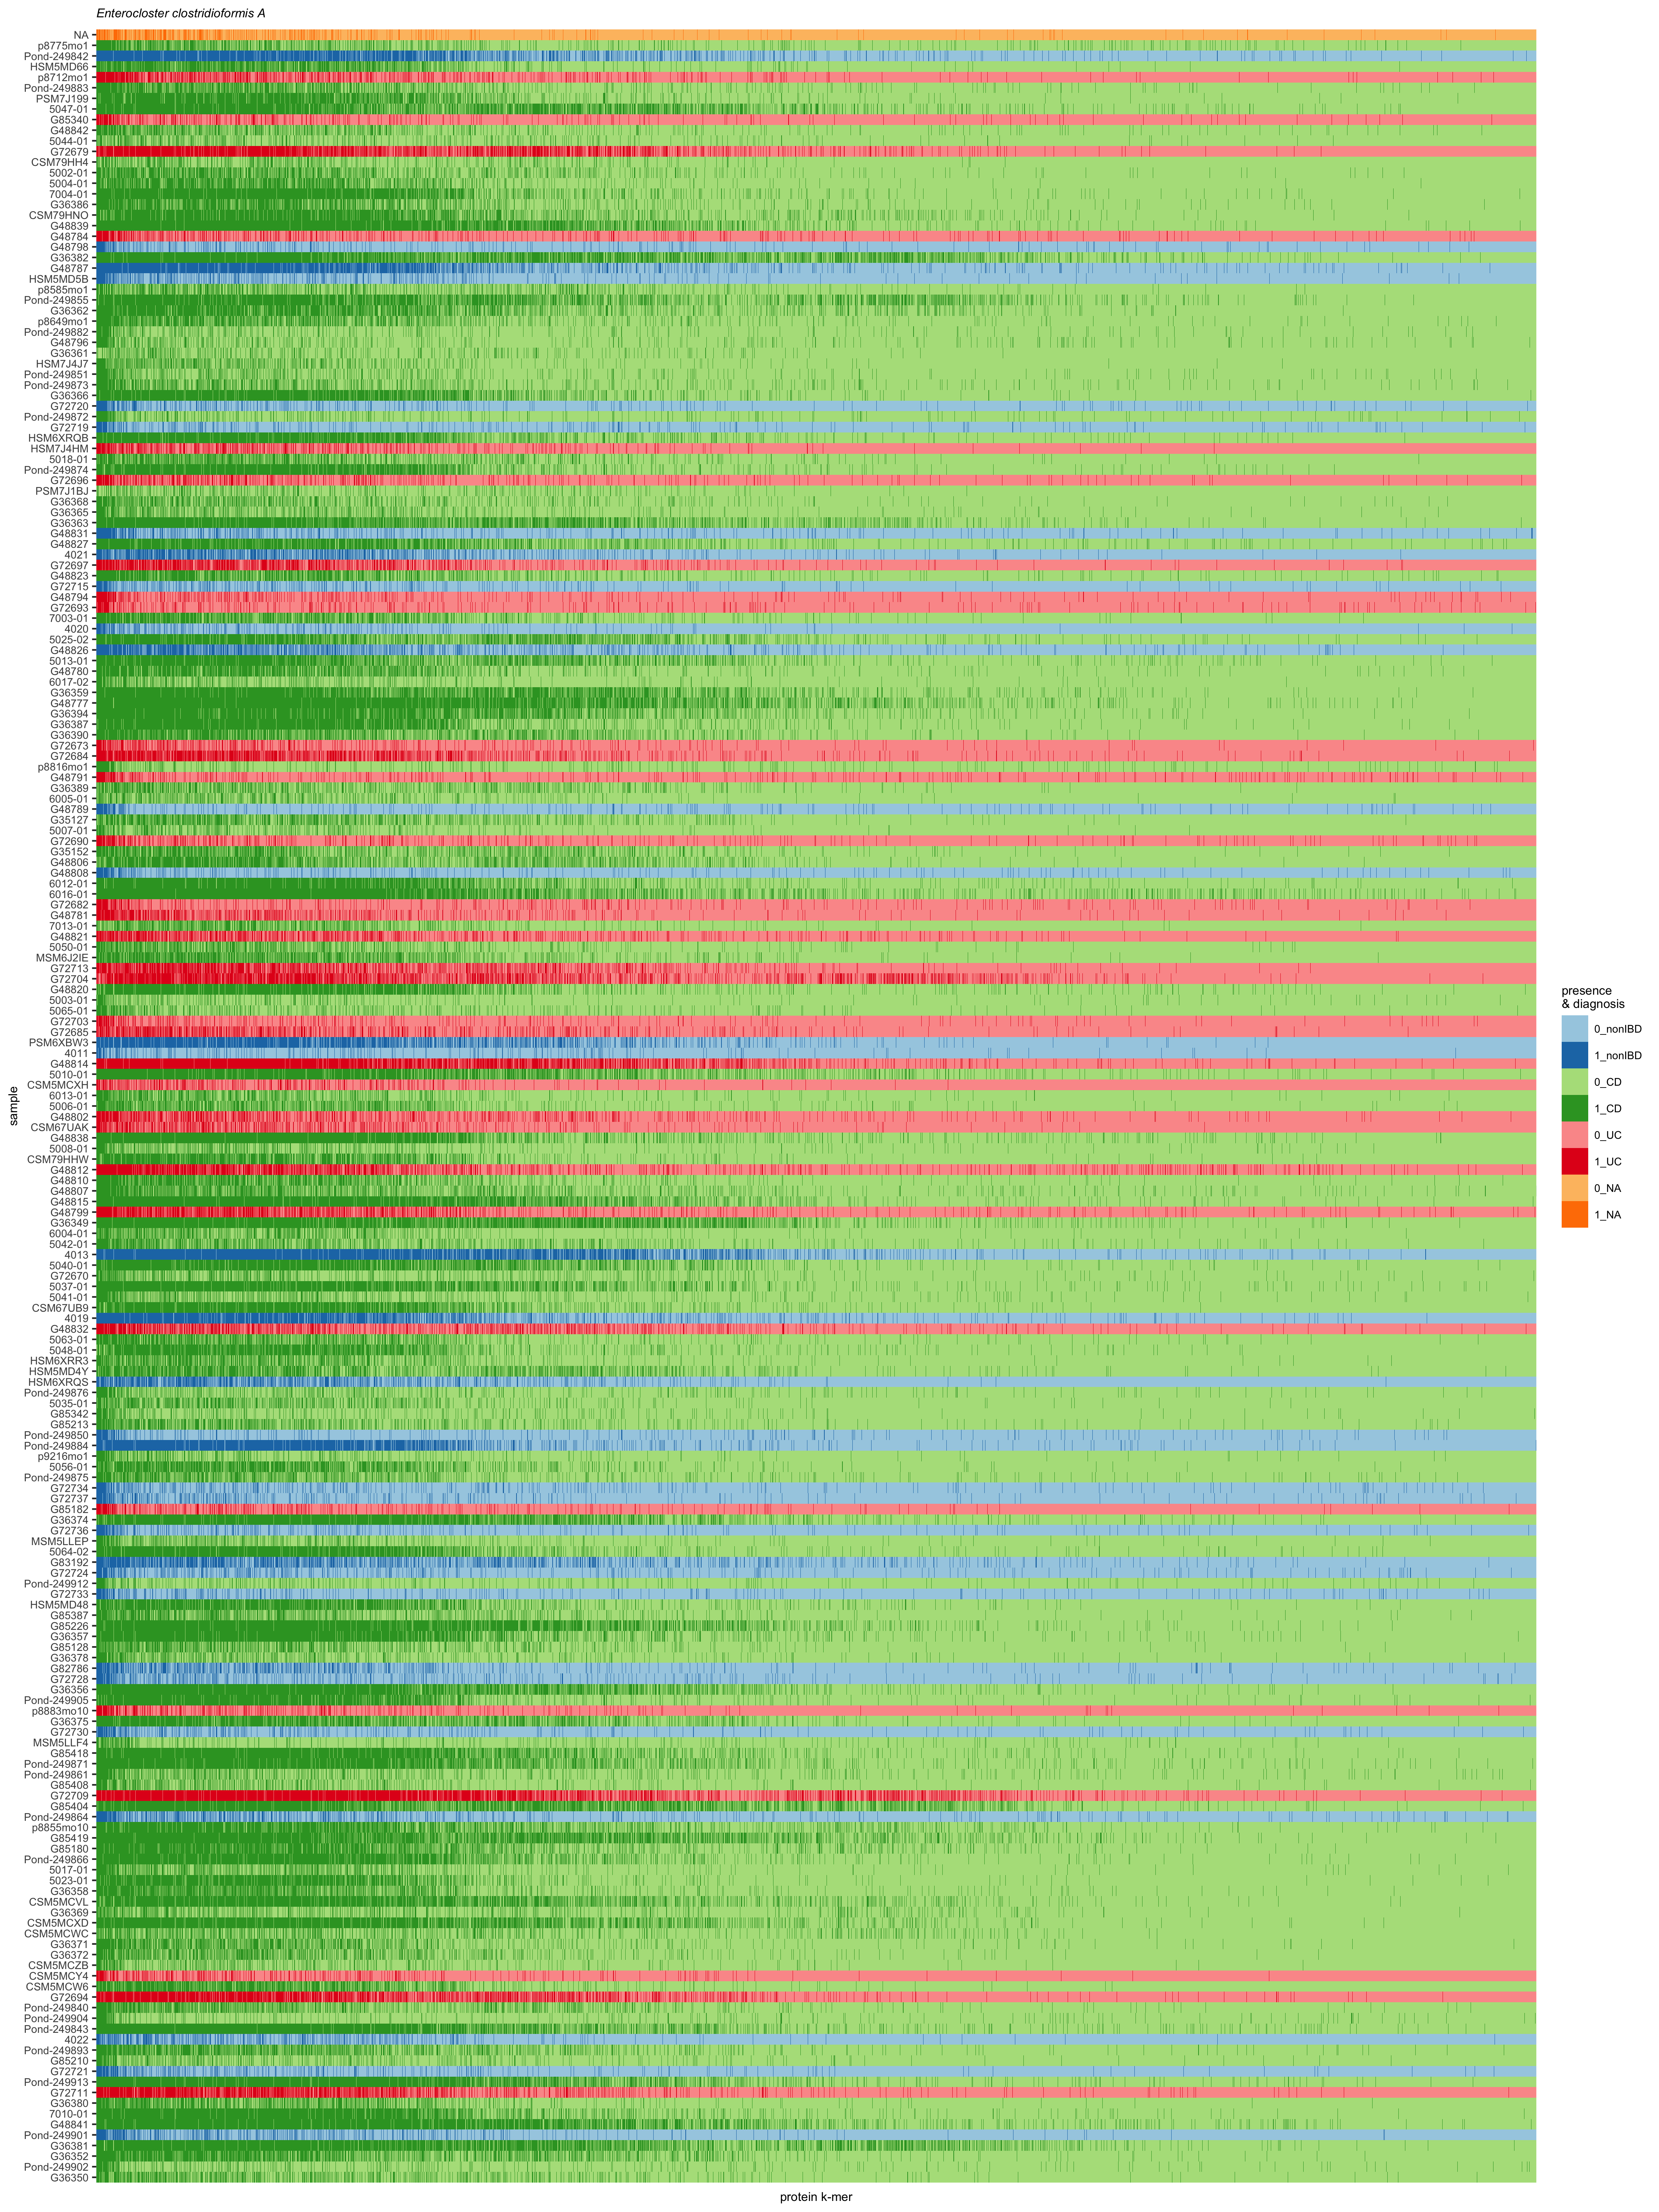

In [54]:
# adjust plot size rendered inline
options(repr.plot.width =15, repr.plot.height = 20, repr.plot.res = 300)

#png("tmp_binmap_A.png", res = 300, units = "in", height = 20, width = 15)
binmap
#dev.off()



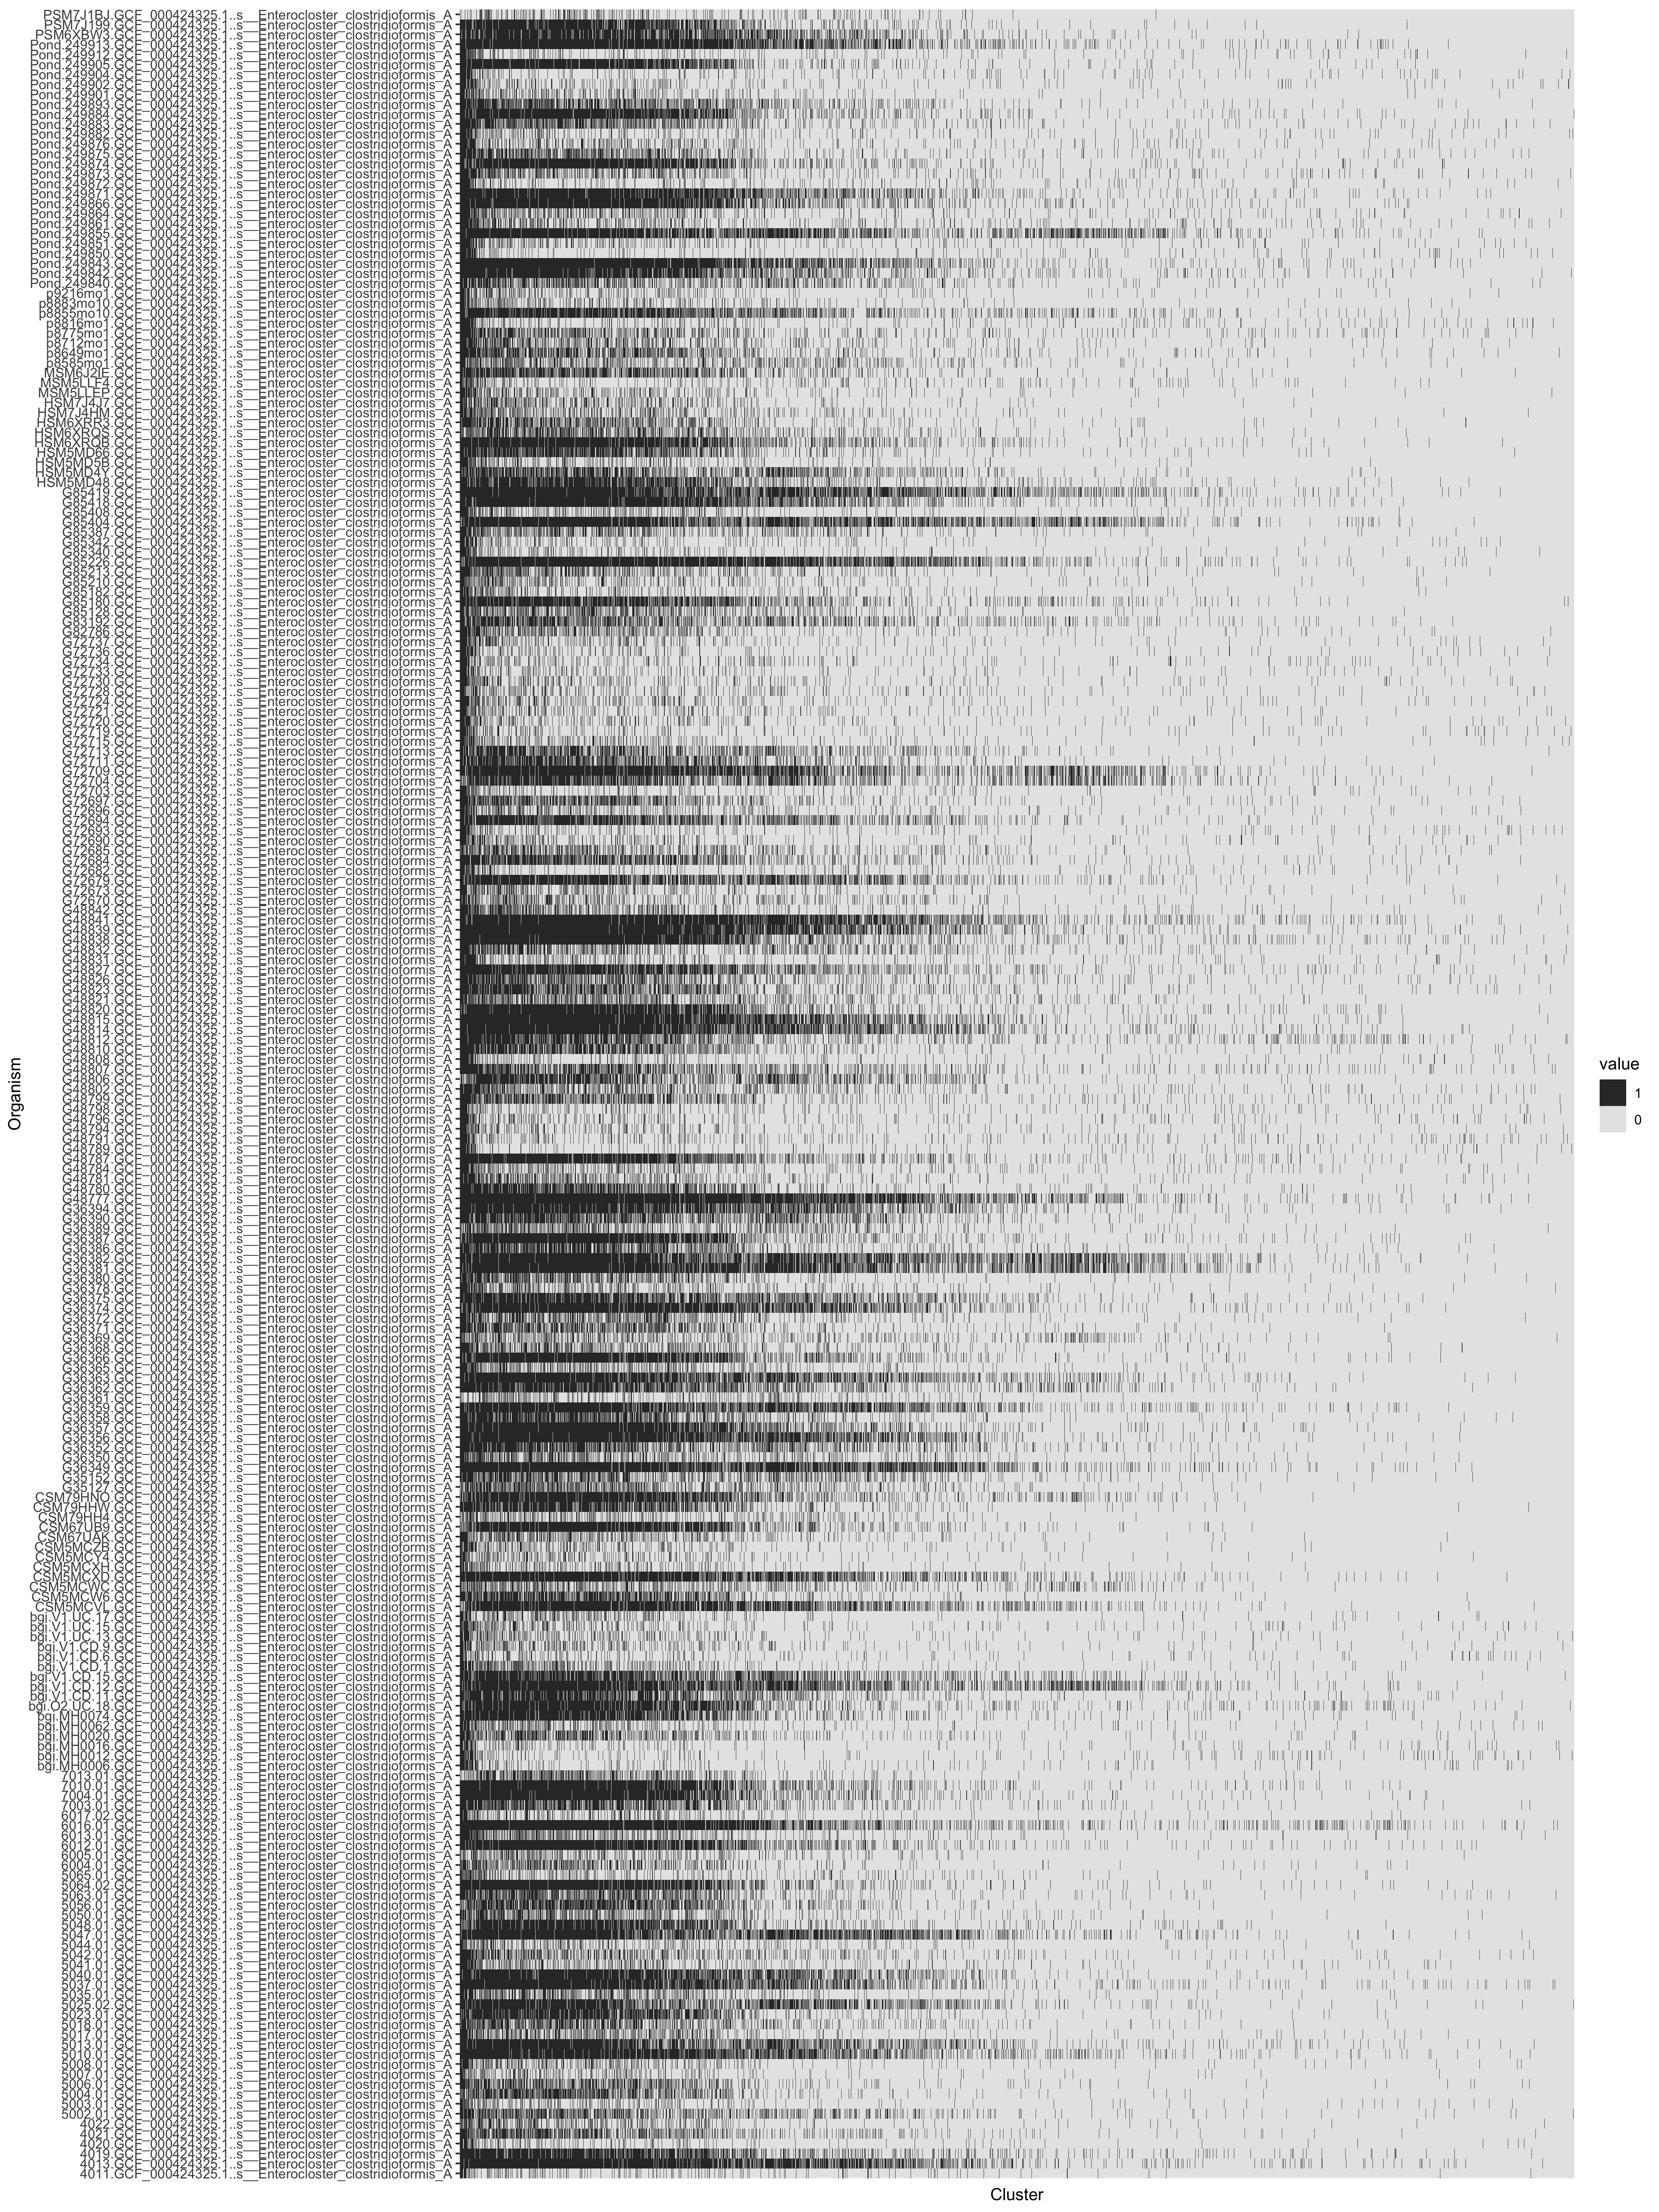

In [55]:
# adjust plot size rendered inline
options(repr.plot.width =15, repr.plot.height = 20, repr.plot.res = 300)

#png("tmp_gg_binmap_A.png", res = 300, units = "in", height = 20, width = 15)
pg$gg_binmap()
#dev.off()